<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>
Author: Vitaly Radchenko, Data Scientist at YouScan

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

# <center>Assignment # 5</center>
## <center>Logistic Regression and Random Forest in the credit scoring problem</center>  

In this assignment, you will build models and answer questions using data on credit scoring.

Please write your code in the cells with the "Your code here" placeholder. Then, answer the questions in the [form](https://drive.google.com/open?id=1P9SAkIRUiznVJd1bzAqRG5AoIpwPfUo3SHfQtDV_tPw).

Let's start with a warm-up exercise.

**Question 1.** There are 5 jurors in a courtroom. Each of them can correctly identify the guilt of the defendant with 70% probability, independent of one another. What is the probability that the jurors will jointly reach the correct verdict if the final decision is by majority vote?

1. 70.00%
2. 83.20%
3. 83.70%
4. 87.50%

$$ \large \mu = \sum_{i=m}^{N}{N\choose i}p^i(1-p)^{N-i} $$

In [63]:
import math
N = 5
m = math.floor(N/2)+1
p = 0.7
print('I am not too sure how to compute it using the above formula')

I am not too sure how to compute it using the above formula


Great! Let's move on to machine learning.

## Credit scoring problem setup

#### Problem

Predict whether the customer will repay their credit within 90 days. This is a binary classification problem; we will assign customers into good or bad categories based on our prediction.

#### Data description

| Feature | Variable Type | Value Type | Description |
|:--------|:--------------|:-----------|:------------|
| age | Input Feature | integer | Customer age |
| DebtRatio | Input Feature | real | Total monthly loan payments (loan, alimony, etc.) / Total monthly income percentage |
| NumberOfTime30-59DaysPastDueNotWorse | Input Feature | integer | The number of cases when client has overdue 30-59 days (not worse) on other loans during the last 2 years |
| NumberOfTimes90DaysLate | Input Feature | integer | Number of cases when customer had 90+dpd overdue on other credits |
| NumberOfTime60-89DaysPastDueNotWorse | Input Feature | integer | Number of cased when customer has 60-89dpd (not worse) during the last 2 years |
| NumberOfDependents | Input Feature | integer | The number of customer dependents |
| SeriousDlqin2yrs | Target Variable | binary: <br>0 or 1 | Customer hasn't paid the loan debt within 90 days |


Let's set up our environment:

In [1]:
# Disable warnings in Anaconda
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8

Let's write the function that will replace *NaN* values with the median for each column.

In [3]:
def fill_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table   

Now, read the data:

In [4]:
data = pd.read_csv('../../data/credit_scoring_sample.csv', sep =';')
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


Look at the variable types:

In [5]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Check the class balance:

Distribution of the target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

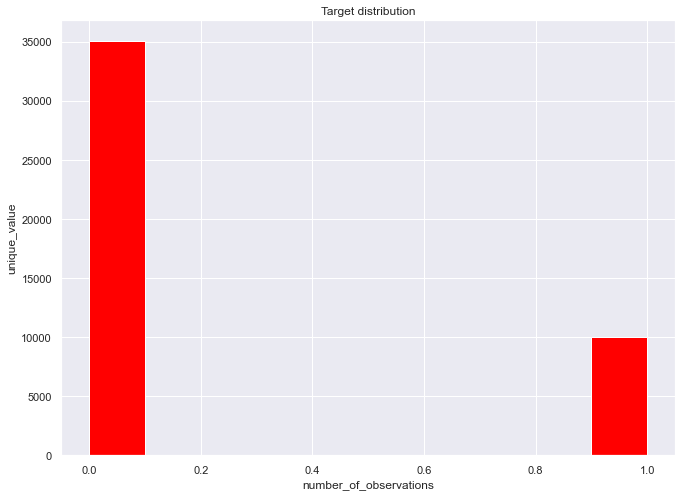

In [6]:
ax = data['SeriousDlqin2yrs'].hist(orientation='vertical', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of the target:')
data['SeriousDlqin2yrs'].value_counts()/data.shape[0]

Separate the input variable names by excluding the target:

In [7]:
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

Apply the function to replace *NaN* values:

In [8]:
table = fill_nan(data)

Separate the target variable and input features:

In [9]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

## Bootstrapping

**Question 2.** Make an interval estimate of the average age for the customers who delayed repayment at the 90% confidence level. Use the example from the article as reference, if needed. Also, use `np.random.seed(0)` as before. What is the resulting interval estimate?

1. 52.59 – 52.86
2. 45.71 – 46.13
3. 45.68 – 46.17
4. 52.56 – 52.88

In [64]:
def get_bootstrap_samples(data, n_samples):
    """Generate bootstrap samples using the bootstrap method."""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    """Produce an interval estimate."""
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

# Save the data about the loyal and former customers to split the dataset
age_of_delayed_repayment_customers = data[data['SeriousDlqin2yrs'] == 1]['age'].values

# Generate the samples using bootstrapping and calculate the mean for each of them
age_mean_scores = [np.mean(sample) for sample in get_bootstrap_samples(age_of_delayed_repayment_customers, 1000)]

#alpha value 0.1 for 90% confidence level

print("The average age interval for the customers who delayed repayment at 90% confidence level is",
      stat_intervals(age_mean_scores, 0.1))
print('The closest correct answer is 2.')

The average age interval for the customers who delayed repayment at 90% confidence level is [45.71435767 46.14836924]
The closest correct answer is 2.


## Logistic regression

Let's set up to use logistic regression:

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score

Now, we will create a `LogisticRegression` model and use `class_weight='balanced'` to make up for our unbalanced classes.

In [68]:
lr = LogisticRegression(random_state=5, class_weight='balanced')

Let's try to find the best regularization coefficient, which is the coefficient `C` for logistic regression. Then, we will have an optimal model that is not overfit and is a good predictor of the target variable.

In [69]:
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}

In order to find the optimal value of `C`, let's apply stratified 5-fold validation and look at the *ROC AUC* against different values of the parameter `C`. Use the `StratifiedKFold` function for this: 

In [70]:
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=5)
pred_test_full =0
cv_score =[]
i=1
for train_index,test_index in skf.split(X,y):
    print('{} of KFold {}'.format(i,skf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y.loc[train_index],y.loc[test_index]
    
    #model
    for coeff in parameters['C']:
        lr = lr = LogisticRegression(random_state=5, class_weight='balanced', C=coeff)
        lr.fit(xtr,ytr)
        score = roc_auc_score(yvl,lr.predict(xvl))
        print('ROC AUC score {} for coeff {}:'.format(score, coeff))
        cv_score.append(score)    

1 of KFold 5
ROC AUC score 0.695072001787768 for coeff 0.0001:
ROC AUC score 0.7285033349844566 for coeff 0.001:
ROC AUC score 0.7323832968947495 for coeff 0.01:
ROC AUC score 0.71518190112618 for coeff 0.1:
ROC AUC score 0.7237788804245093 for coeff 1:
ROC AUC score 0.7154312776847833 for coeff 10:
1 of KFold 5
ROC AUC score 0.6990260151561736 for coeff 0.0001:
ROC AUC score 0.7262242866008496 for coeff 0.001:
ROC AUC score 0.7188233041824662 for coeff 0.01:
ROC AUC score 0.7191073400972454 for coeff 0.1:
ROC AUC score 0.7198853963834706 for coeff 1:
ROC AUC score 0.7266449316207197 for coeff 10:
1 of KFold 5
ROC AUC score 0.7010711834810966 for coeff 0.0001:
ROC AUC score 0.7160063978181056 for coeff 0.001:
ROC AUC score 0.7192124923929508 for coeff 0.01:
ROC AUC score 0.7193903874220068 for coeff 0.1:
ROC AUC score 0.7193903874220068 for coeff 1:
ROC AUC score 0.7193903874220068 for coeff 10:
1 of KFold 5
ROC AUC score 0.7046445538786116 for coeff 0.0001:
ROC AUC score 0.72421322888

One of the important metrics of model quality is the *Area Under the Curve (AUC)*. *ROC AUC* varies from 0 to 1. The closer ROC AUC is to 1, the better the quality of the classification model.

**Question 3.** Perform a *Grid Search* with the scoring metric "roc_auc" for the parameter `C`. Which value of the parameter `C` is optimal? 

1. 0.0001
2. 0.001
3. 0.01
4. 0.1
5. 1
6. 10

In [74]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(lr, parameters, scoring='roc_auc', refit=True, cv=5)

clf.fit(X,y)
print('The optimal value of C is {}'.format(clf.best_params_))

The optimal value of C is {'C': 0.001}


**Question 4.** Can we consider the best model stable? The model is *stable* if the standard deviation on validation is less than 0.5%. Save the *ROC AUC* value of the best model; it will be useful for the following tasks.

1. Yes
2. No

In [72]:
roc_auc_best_score_lr = clf.best_score_
print('The ROC AUC value is {:.4}'.format(roc_auc_best_score_lr))
print('Not too sure how to calc standard deviation on validation')

The ROC AUC value is 0.8042


## Feature importance

**Question 5.** *Feature importance* is defined by the absolute value of its corresponding coefficient. First, you need to normalize all of the feature values so that it will be valid to compare them. What is the most important feature for the best logistic regression model?

1. age
2. NumberOfTime30-59DaysPastDueNotWorse
3. DebtRatio
4. NumberOfTimes90DaysLate
5. NumberOfTime60-89DaysPastDueNotWorse
6. MonthlyIncome
7. NumberOfDependents

In [85]:
import pprint

from sklearn.preprocessing import StandardScaler
lr = LogisticRegression(C=0.001, random_state=5, class_weight='balanced')
scal = StandardScaler()
lr.fit(scal.fit_transform(X), y)
feature_coeff_dict = dict(zip(independent_columns_names, lr.coef_.flatten().tolist()))
pprint.pprint(feature_coeff_dict)

print('Looking at feature coeff dict, the most important feature is NumberOfTime30-59DaysPastDueNotWorse.')

{'DebtRatio': -0.02409605224751083,
 'MonthlyIncome': -0.16314631733039306,
 'NumberOfDependents': 0.10144319526520428,
 'NumberOfTime30-59DaysPastDueNotWorse': 0.7234269813289962,
 'NumberOfTime60-89DaysPastDueNotWorse': 0.19355763717568433,
 'NumberOfTimes90DaysLate': 0.5167876396300681,
 'age': -0.41670229389926805}
Looking at feature coeff dict, the most important feature is NumberOfTime30-59DaysPastDueNotWorse.


**Question 6.** Calculate how much `DebtRatio` affects our prediction using the [softmax function](https://en.wikipedia.org/wiki/Softmax_function). What is its value?

1. 0.38
2. -0.02
3. 0.11
4. 0.24

In [18]:
# softmax function from https://stackoverflow.com/questions/34968722/how-to-implement-the-softmax-function-in-python
# e ^ x / sum(e ^ x)
softmax_output = np.exp(lr.coef_[0]) / np.sum(np.exp(lr.coef_[0]))
print(softmax_output)
print(softmax_output[2]) # index of 'DebtRatio'

print('The correct answer is 3 - {:.2}'.format(softmax_output[2]))

[0.0771617  0.24129794 0.11426375 0.19625073 0.14204772 0.09943052
 0.12954763]
0.11426375283065268
The correct answer is 3 - 0.11


**Question 7.** Let's see how we can interpret the impact of our features. For this, recalculate the logistic regression with absolute values, that is without scaling. Next, modify the customer's age by adding 20 years, keeping the other features unchanged. How many times will the chance that the customer will not repay their debt increase? You can find an example of the theoretical calculation [here](https://www.unm.edu/~schrader/biostat/bio2/Spr06/lec11.pdf).

1. -0.01
2. 0.70
3. 8.32
4. 0.66

In [19]:

lr = LogisticRegression(C=0.001, random_state=5, class_weight='balanced')
lr.fit(X, y)
feature_coeff_dict_lr = dict(zip(independent_columns_names, lr.coef_.flatten().tolist()))
pprint.pprint(feature_coeff_dict_lr)

# Not sure about the second part of the problem

{'DebtRatio': -6.493879385085218e-06,
 'MonthlyIncome': -1.1478366408456345e-05,
 'NumberOfDependents': 0.19172613684183543,
 'NumberOfTime30-59DaysPastDueNotWorse': 0.4468323405710366,
 'NumberOfTime60-89DaysPastDueNotWorse': 0.21603824437811753,
 'NumberOfTimes90DaysLate': 0.3903808107922781,
 'age': -0.01365552423017368}


## Random Forest

Import the Random Forest classifier:

In [76]:
from sklearn.ensemble import RandomForestClassifier

Initialize Random Forest with 100 trees and balance target classes:

In [77]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, 
                            class_weight='balanced')

We will search for the best parameters among the following values:

In [78]:
parameters = {'max_features': [1, 2, 4], 'min_samples_leaf': [3, 5, 7, 9], 'max_depth': [5,10,15]}

Also, we will use the stratified k-fold validation again. You should still have the `skf` variable.

**Question 8.** How much higher is the *ROC AUC* of the best random forest model than that of the best logistic regression on validation?

1. 4%
2. 3%
3. 2%
4. 1%

In [79]:
rf_grid_search = GridSearchCV(rf, parameters, scoring='roc_auc', cv=skf)
rf_grid_search.fit(X, y)
rf_roc_auc = rf_grid_search.best_score_


In [81]:
print('rf_roc_auc', rf_roc_auc)
rf_roc_auc_perc = ((rf_roc_auc - roc_auc_best_score_lr)/rf_roc_auc)*100
print(rf_roc_auc_perc)
print('The ROC AUC for random forest is higher by {} so the closest answer is 1.'.format(rf_roc_auc_perc))

rf_roc_auc 0.8357174834725474
3.777087474192768
The ROC AUC for random forest is higher by 3.777087474192768 so the closest answer is 1.


**Question 9.** What feature has the weakest impact in the Random Forest model?

1. age
2. NumberOfTime30-59DaysPastDueNotWorse
3. DebtRatio
4. NumberOfTimes90DaysLate
5. NumberOfTime60-89DaysPastDueNotWorse
6. MonthlyIncome
7. NumberOfDependents

In [82]:
fetaure_importances = rf_grid_search.best_estimator_.feature_importances_

feature_imp = pd.Series(fetaure_importances, index=independent_columns_names).sort_values(ascending=True)
print(feature_imp)

print('"NumberOfDependents" (Answer - 7) is the least important feature.')

NumberOfDependents                      0.011600
MonthlyIncome                           0.059142
DebtRatio                               0.089620
age                                     0.100434
NumberOfTime60-89DaysPastDueNotWorse    0.128935
NumberOfTime30-59DaysPastDueNotWorse    0.295335
NumberOfTimes90DaysLate                 0.314934
dtype: float64
"NumberOfDependents" (Answer - 7) is the least important feature.


**Question 10.** What is the most significant advantage of using *Logistic Regression* versus *Random Forest* for this problem?

1. Spent less time for model fitting;
2. Fewer variables to iterate;
3. Feature interpretability;
4. Linear properties of the algorithm.

In [83]:
print('I think the time spent on model fitting was less as compared to Random Forest, RF took exceptionally long so the answer is 1.')

I think the time spent on model fitting was less as compared to Random Forest, RF took exceptionally long so the answer is 1.


## Bagging

Import modules and set up the parameters for bagging:

In [84]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

parameters = {'max_features': [2, 3, 4], 'max_samples': [0.5, 0.7, 0.9], 
              'base_estimator__C': [0.0001, 0.001, 0.01, 1, 10, 100]}

**Question 11.** Fit a bagging classifier with `random_state=42`. For the base classifiers, use 100 logistic regressors and use `RandomizedSearchCV` instead of `GridSearchCV`. It will take a lot of time to iterate over all 54 variants, so set the maximum number of iterations for `RandomizedSearchCV` to 20. Don't forget to set the parameters `cv` and `random_state=1`. What is the best *ROC AUC* you achieve?

1. 80.75%
2. 80.12%
3. 79.62%
4. 76.50%

In [66]:
bg_clf = BaggingClassifier(LogisticRegression(class_weight='balanced'), 
                           n_estimators=100, random_state=42)

random_cv = RandomizedSearchCV(bg_clf, parameters, scoring='roc_auc', n_iter=20, random_state=1)
random_cv.fit(X,y)


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=BaggingClassifier(base_estimator=LogisticRegression(C=1.0,
                                                                                 class_weight='balanced',
                                                                                 dual=False,
                                                                                 fit_intercept=True,
                                                                                 intercept_scaling=1,
                                                                                 l1_ratio=None,
                                                                                 max_iter=100,
                                                                                 multi_class='auto',
                                                                                 n_jobs=None,
                                                                               

In [86]:
roc_auc_random_cv = random_cv.best_score_
print(roc_auc_random_cv)
print('The closest answer is 1.')

0.807040646303409
The closest answer is 1.


**Question 12.** Give an interpretation of the best parameters for bagging. Why are these values of `max_features` and `max_samples` the best?

1. For bagging it's important to use as few features as possible;
2. Bagging works better on small samples;
3. Less correlation between single models;
4. The higher the number of features, the lower the loss of information.

In [87]:
print('From the bagging document provided in the lecture, it looks like the Bagging works better on small samples so the answer is 2.')

From the bagging document provided in the lecture, it looks like the Bagging works better on small samples so the answer is 2.
